In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# import dataset

current_os = 'mac'
if current_os == 'mac':
    path = '/Users/fabienaugsburger/Documents/GitHub/master-project/'
elif current_os == 'win':
    path = 'C:/Users/fabau/OneDrive/Documents/GitHub/master-project/'
else:
    print('Error: OS not recognized')

# load data

dataset = 'X_y_EU_1h'
osaa = 2

if osaa == '':
    X_train = np.load(path + f'DATASETS/{dataset}/X_train.npy')
    X_test = np.load(path + f'DATASETS/{dataset}/X_test.npy')
    y_train = np.load(path + f'DATASETS/{dataset}/y_train.npy')
    y_test = np.load(path + f'DATASETS/{dataset}/y_test.npy')
    X_validation = np.load(path + f'DATASETS/{dataset}/X_validation.npy')
    y_validation = np.load(path + f'DATASETS/{dataset}/y_validation.npy')
else:
    X_train = np.load(path + f'DATASETS/{dataset}/X_train_{osaa}.npy')
    X_test = np.load(path + f'DATASETS/{dataset}/X_test_{osaa}.npy')
    y_train = np.load(path + f'DATASETS/{dataset}/y_train_{osaa}.npy')
    y_test = np.load(path + f'DATASETS/{dataset}/y_test_{osaa}.npy')
    X_validation = np.load(path + f'DATASETS/{dataset}/X_validation_{osaa}.npy')
    y_validation = np.load(path + f'DATASETS/{dataset}/y_validation_{osaa}.npy')



names = pd.read_csv(path + f'variable_list_24_v5_wo_i.csv')

if osaa == 2:
    X_train=pd.DataFrame(X_train, columns=names['variables'])
    X_test=pd.DataFrame(X_test, columns=names['variables'])
    X_validation=pd.DataFrame(X_validation, columns=names['variables'])
    
    y_train=pd.DataFrame(y_train, columns=['instantaneous_10m_wind_gust_0'])
    y_test=pd.DataFrame(y_test, columns=['instantaneous_10m_wind_gust_0'])
    y_validation=pd.DataFrame(y_validation, columns=['instantaneous_10m_wind_gust_0'])

In [3]:
from sklearn.ensemble import RandomForestRegressor

# create a regressor object
regressor = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=10)

# fit the regressor with X and Y data
regressor.fit(X_train,np.ravel(y_train))

# predict the target on the train dataset
y_test_pred = regressor.predict(X_test)

# mse of the model

from sklearn.metrics import mean_squared_error

print('Mean Squared Error:', mean_squared_error(y_test, y_test_pred))

Mean Squared Error: 5.967481310354425


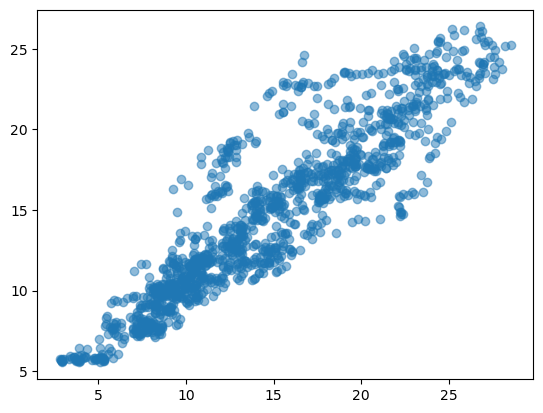

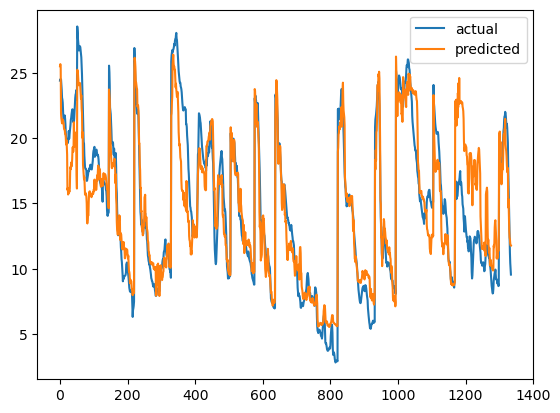

In [11]:
# see the difference between the prediction and the actual values

plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.show()
plt.plot(y_test)
plt.plot(y_test_pred)
plt.legend(['actual', 'predicted']) 
plt.show()

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


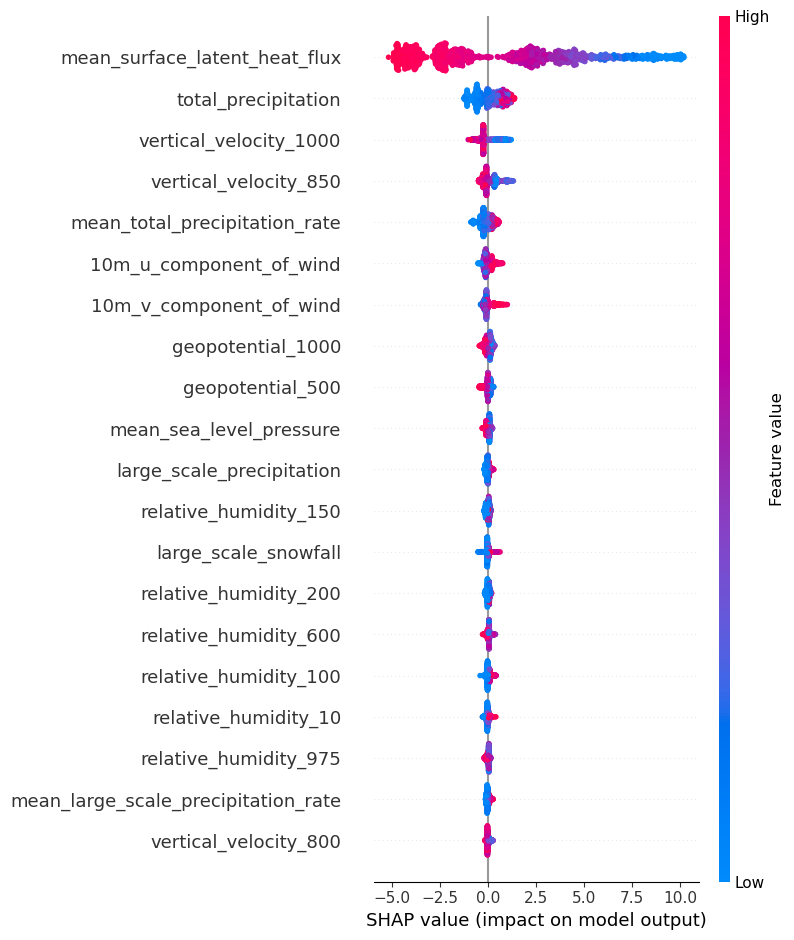

<Figure size 640x480 with 0 Axes>

In [16]:
import shap

# Create a SHAP explainer
explainer = shap.TreeExplainer(regressor)
shap_values = explainer.shap_values(X_test)

# Plot the SHAP values for feature importance
shap.summary_plot(shap_values, X_test)

plt.savefig(path + f'Tree_predictions/shap_{dataset}_{osaa}.png', dpi=300)

In [15]:
# save the plot

plt.savefig(path + f'Tree_predictions/shap_{dataset}_{osaa}.png', dpi=300)
plt.show()

<Figure size 640x480 with 0 Axes>

In [164]:
explainer2 = shap.explainers.GPUTree(regressor, feature_perturbation="tree_path_dependent")
interaction_shap_values = explainer2(X_test, interactions=True)

shap.plots.scatter(interaction_shap_values[:, :, 0])

cuda extension was not built during install!


ImportError: cannot import name '_cext_gpu' from partially initialized module 'shap' (most likely due to a circular import) (/Users/fabienaugsburger/anaconda3/envs/master/lib/python3.11/site-packages/shap/__init__.py)

In [18]:
from lime import lime_tabular

# Create a LIME explainer
explainer_2 = lime_tabular.LimeTabularExplainer(
    training_data=X_train.values, 
    feature_names=X_train.columns, 
    mode='regression'
)

# Explain a prediction
i = 3  # index of the instance to explain
exp = explainer_2.explain_instance(X_train.iloc[i].values, regressor.predict)
exp.show_in_notebook(show_all=True)

X does not have valid feature names, but RandomForestRegressor was fitted with feature names


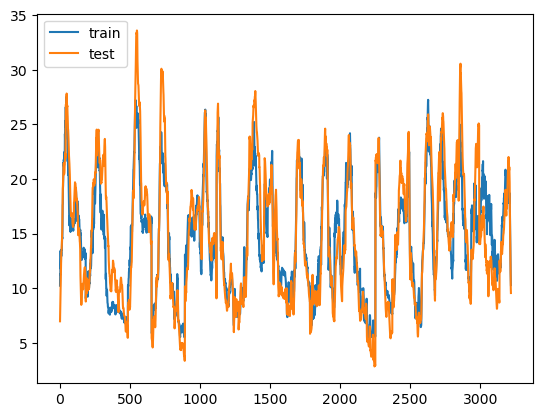

Text(0, 0.5, 'Predictions')

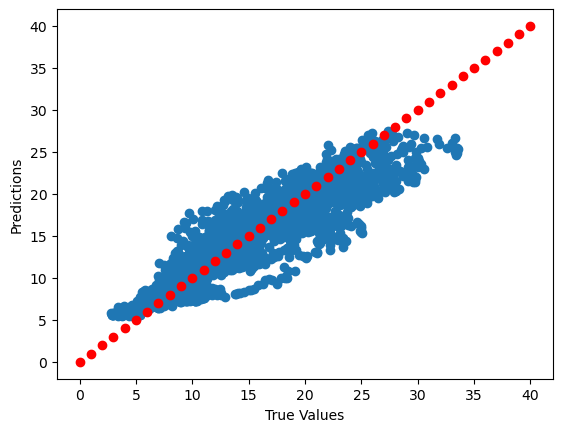

In [183]:
import matplotlib.pyplot as plt
#for i in range(len(y_test)):
plt.plot(y_test_pred),
plt.plot(y_test),
plt.legend(['train', 'test'])
plt.show()

plt.scatter(y_test, y_test_pred)
seq = np.linspace(0, 40, 41)
plt.scatter(seq, seq, color='red')
plt.xlabel('True Values')
plt.ylabel('Predictions')

# it works !

In [24]:
#%%% with hyperparameters tuning 
# Tune of the hyperparameters for the Random Forest with parameters
# For 'max_leaf_nodes', let's search between 60 and 200 and for 'min_samples_split', let's search between 5 and 30

# convert y_train to 1D array

y_train = np.ravel(y_train)
y_test = np.ravel(y_test)
y_validation = np.ravel(y_validation)

# param_grid helps to define the hyperparameters you would like to test, and the ranges the hyperparameters should be in
param_grid = {'max_features':['sqrt', 'log2', None],
              'min_samples_split':np.arange(5,30,5),
              'n_estimators': np.arange(50, 300, 20),
              'max_depth': np.arange(5,100,5)}

# Then, perform the GridSearch on the RandomForest

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
import time

rf_custom = HalvingGridSearchCV(RandomForestRegressor(random_state=42),
                                param_grid,
                                cv=10,
                                verbose=1, 
                                n_jobs=8, 
                                random_state=42,
                                min_resources=40)

# Next, try a new fit with the training data
start_time = time.time()
rf_custom.fit(X_train,y_train)
elapsed_time_RF = time.time() - start_time
print(f"Elapsed time to fit the training set with tuned hyperparameters RF : {elapsed_time_RF:.3f} seconds")
#%%% The tuning hyperparameters
# Best estimators are the following:

print('Best estimators are the following:',rf_custom.best_estimator_)

n_iterations: 5
n_required_iterations: 8
n_possible_iterations: 5
min_resources_: 40
max_resources_: 4959
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 3705
n_resources: 40
Fitting 10 folds for each of 3705 candidates, totalling 37050 fits
----------
iter: 1
n_candidates: 1235
n_resources: 120
Fitting 10 folds for each of 1235 candidates, totalling 12350 fits
----------
iter: 2
n_candidates: 412
n_resources: 360
Fitting 10 folds for each of 412 candidates, totalling 4120 fits
----------
iter: 3
n_candidates: 138
n_resources: 1080
Fitting 10 folds for each of 138 candidates, totalling 1380 fits
----------
iter: 4
n_candidates: 46
n_resources: 3240
Fitting 10 folds for each of 46 candidates, totalling 460 fits


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


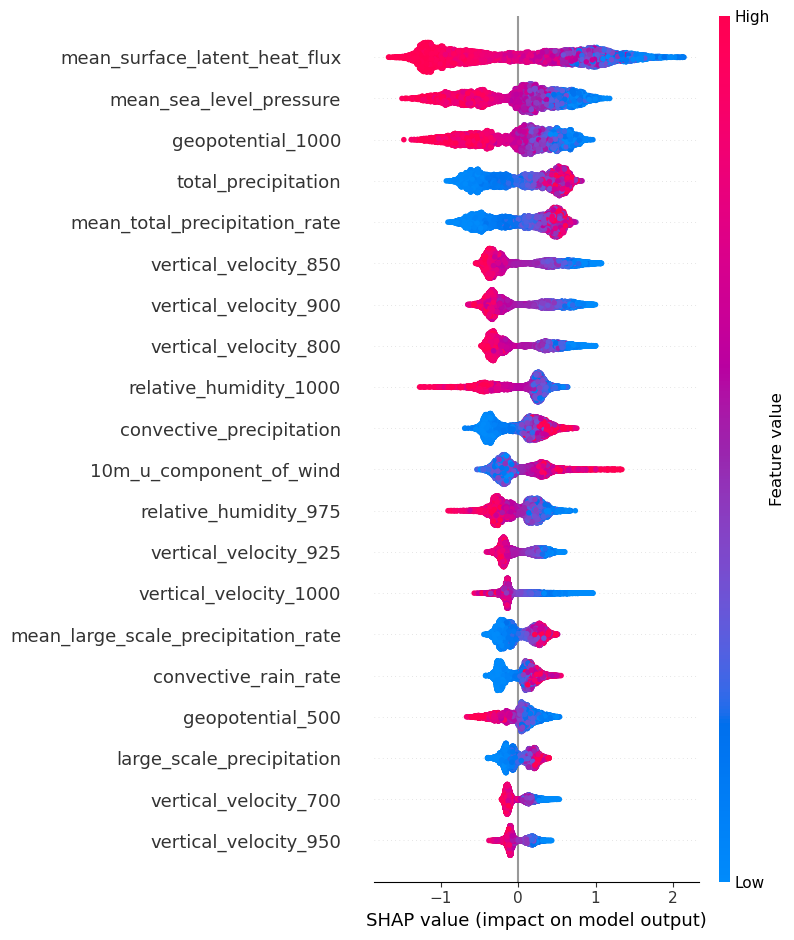

In [159]:
# see the feature importance with the best estimator



# Create a SHAP explainer
explainer = shap.TreeExplainer(rf_custom.best_estimator_)
shap_values = explainer.shap_values(X_train) 

# Plot the SHAP values for feature importance
shap.summary_plot(shap_values, X_train)

Elapsed time to compute the importances: 0.015 seconds


Text(0, 0.5, 'Mean decrease in impurity')

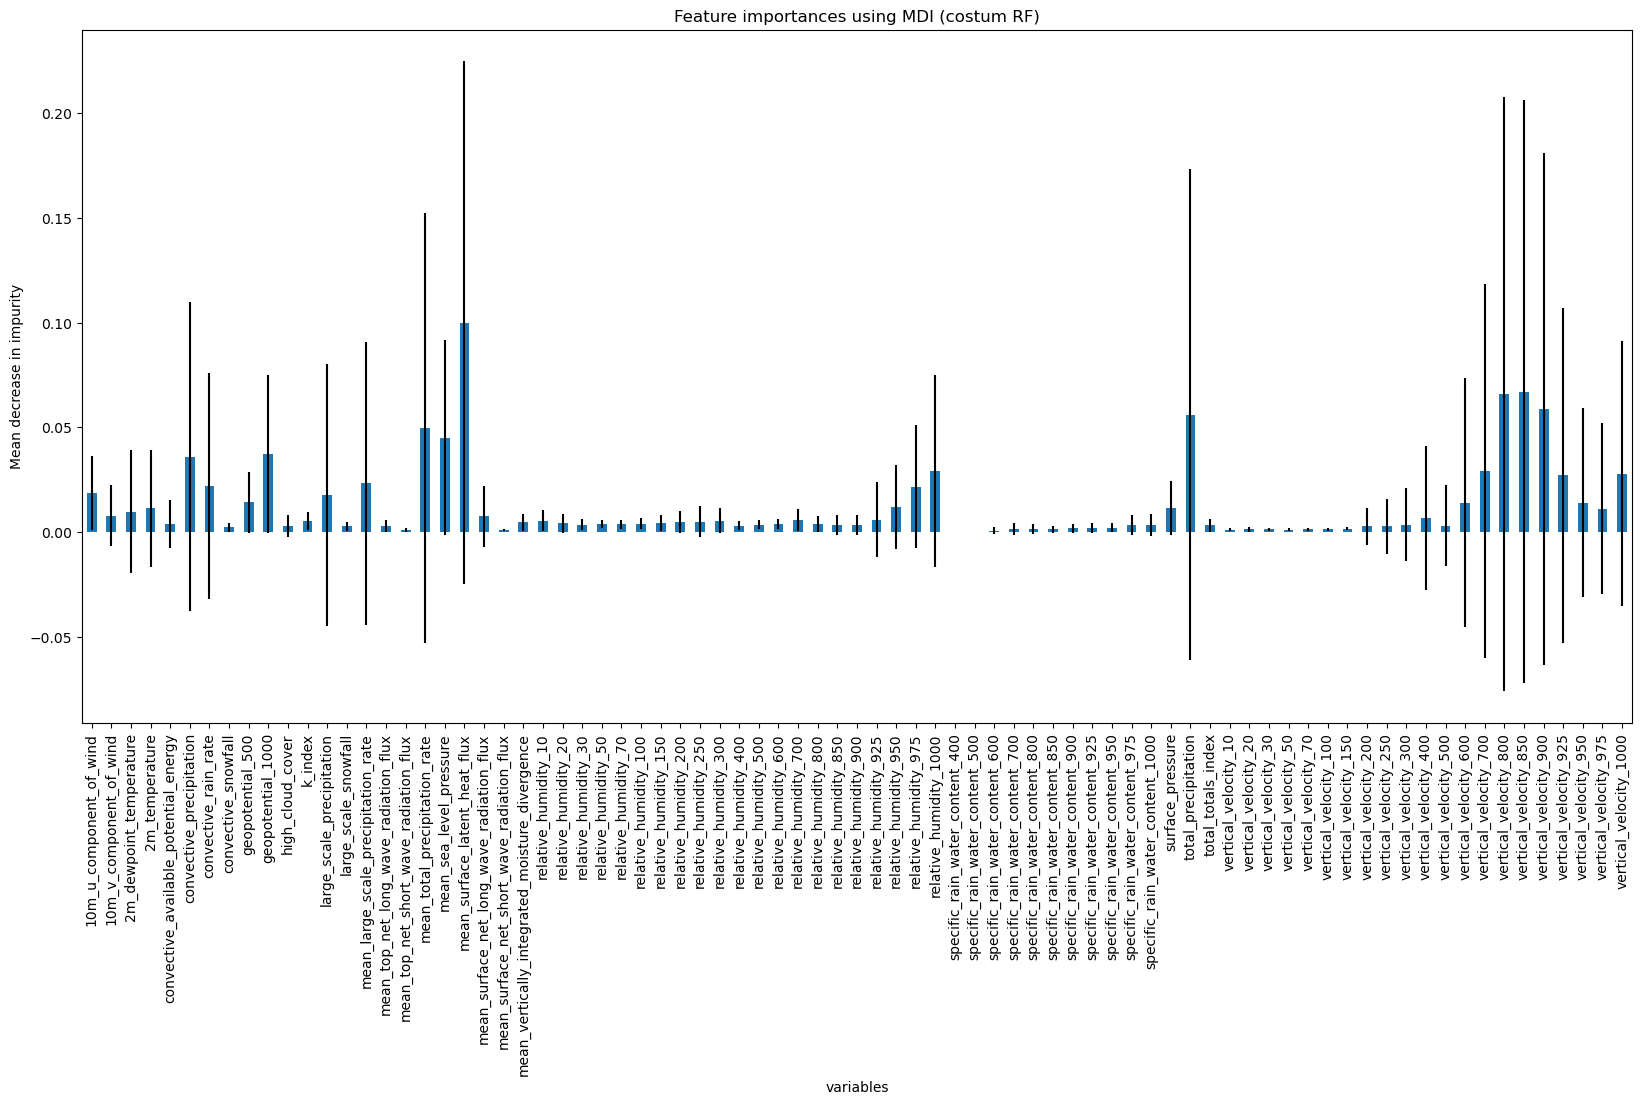

In [165]:
import time
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

start_time = time.time()
importances = rf_custom.best_estimator_.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_custom.best_estimator_.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

# Let's see the features importance
# This cell was copied also from https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html

forest_importances = pd.Series(importances, index=names['variables'])

fig, ax = plt.subplots(1,figsize=(20,9))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI (costum RF)")
ax.set_ylabel("Mean decrease in impurity")
#fig.tight_layout()

In [184]:
y_test_pred = rf_custom.best_estimator_.predict(X_test)

# mse of the model

from sklearn.metrics import mean_squared_error

print('Mean Squared Error:', mean_squared_error(y_test, y_test_pred))

# save it

import pickle

with open(path + 'Tree_predictions/RF_custom.pkl', 'wb') as file:
    pickle.dump(rf_custom.best_estimator_, file)

Mean Squared Error: 6.693053313207422


In [185]:
forest_importances = pd.Series(rf_custom.best_estimator_.importances_mean, index=names['variables'])

# Let's see the resutls. The higher the bar is, the more important the feature is

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=rf_custom.best_estimator_.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on costum RF")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

AttributeError: 'RandomForestRegressor' object has no attribute 'importances_mean'

Mean Squared Error: 4.991646147648482


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


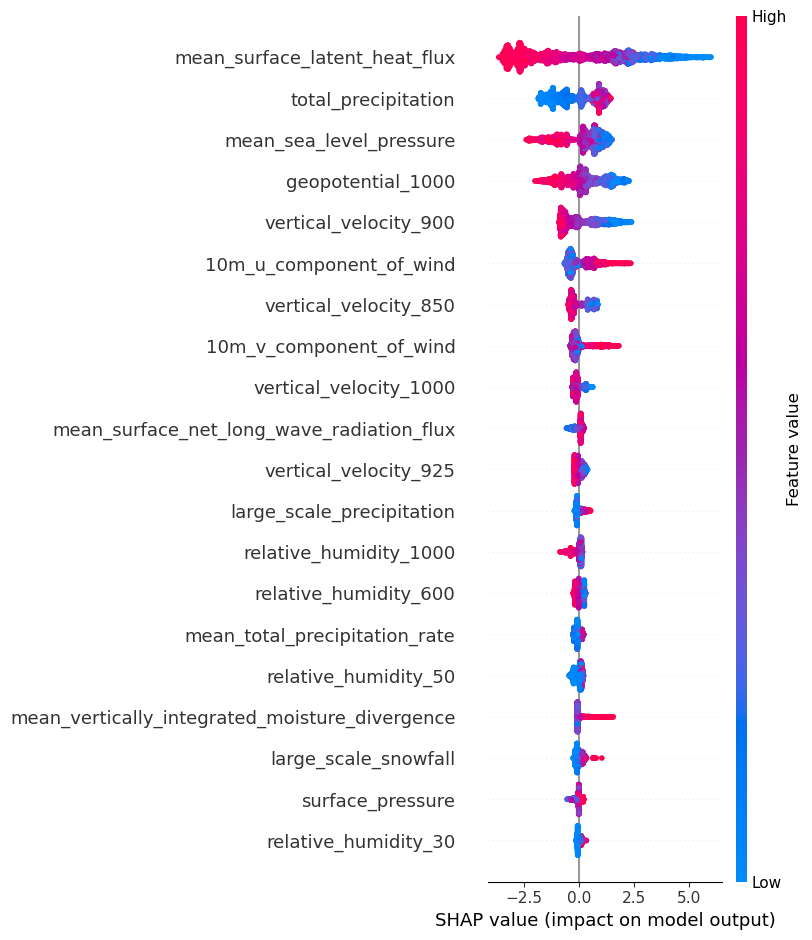

In [186]:
# use gradient boosting regressor

from sklearn.ensemble import GradientBoostingRegressor

# create a regressor object

regressor = GradientBoostingRegressor(n_estimators=100, 
                                      random_state=4)

# fit the regressor with X and Y data

regressor.fit(X_train,y_train)

# predict the target on the train dataset

y_test_pred = regressor.predict(X_test)

# mse of the model

from sklearn.metrics import mean_squared_error

print('Mean Squared Error:', mean_squared_error(y_test, y_test_pred))

# Create a SHAP explainer

explainer = shap.TreeExplainer(regressor)
shap_values = explainer.shap_values(X_test)

# Plot the SHAP values for feature importance

shap.summary_plot(shap_values, X_test)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002909 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19718
[LightGBM] [Info] Number of data points in the train set: 10192, number of used features: 79
[LightGBM] [Info] Start training from score 14.334411
Mean Squared Error: 4.582937394712525


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


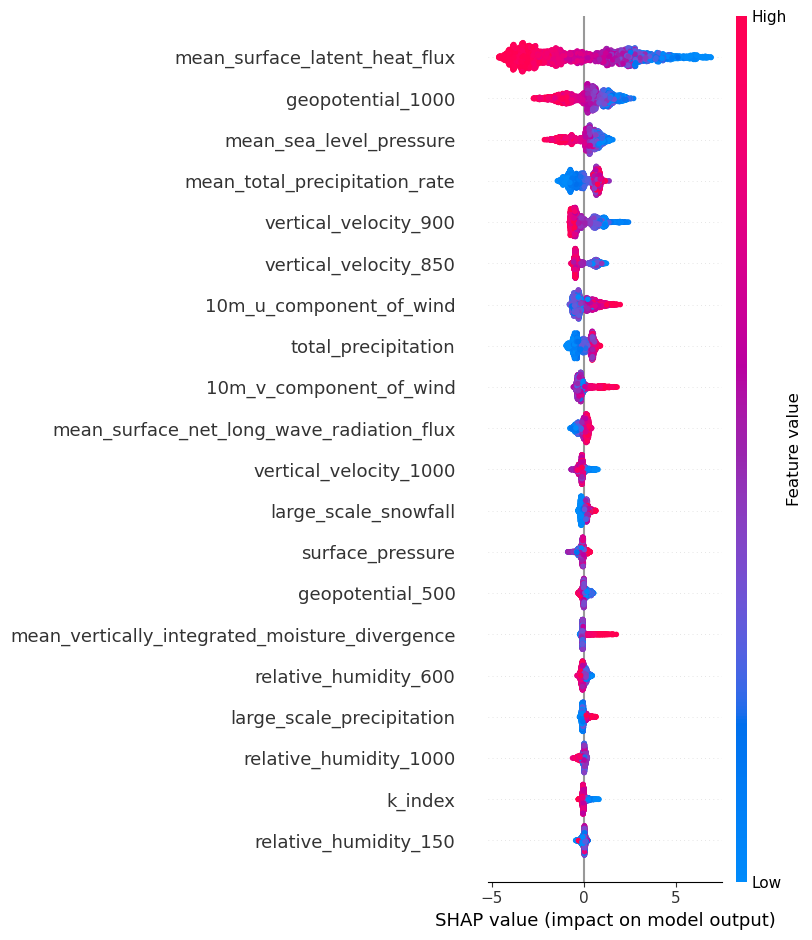

In [187]:
# the same using lightgbm

import lightgbm as lgb

# create a regressor object

regressor = lgb.LGBMRegressor(n_estimators=100,
                                random_state=42)

# fit the regressor with X and Y data

regressor.fit(X_train,y_train)

# predict the target on the train dataset

y_test_pred = regressor.predict(X_test)

# mse of the model

from sklearn.metrics import mean_squared_error

print('Mean Squared Error:', mean_squared_error(y_test, y_test_pred))

# Create a SHAP explainer

explainer = shap.TreeExplainer(regressor)
shap_values = explainer.shap_values(X_test)

# Plot the SHAP values for feature importance

shap.summary_plot(shap_values, X_test)